In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder

# === 1. Cargar el CSV ===
df = pd.read_csv("df_nn.csv", parse_dates=["Fecha"])

# === 2. Filtrar fechas válidas ===
df2024=df.copy()
df = df[(df["Fecha"] >= "2014-01-01") & (df["Fecha"] <= "2023-12-31")].copy()

# === 3. Eliminar valores negativos
df = df[df["Energia_GWh"] >= 0]

# === 4. Crear columna Mes
df["Mes"] = df["Fecha"].dt.to_period("M").dt.to_timestamp()

# === 5. Identificar series válidas (>=119 meses)
series = df.groupby(["Latitud", "Longitud", "Grupo_Consumo"])["Mes"].nunique().reset_index()
series.columns = ["Lat", "Lon", "Grupo", "Meses_disponibles"]
series_validas = series[series["Meses_disponibles"] >= 119]

# === 6. Filtrar DataFrame a solo series válidas
df = df.merge(series_validas, how="inner", left_on=["Latitud", "Longitud", "Grupo_Consumo"],
              right_on=["Lat", "Lon", "Grupo"])
df = df.drop(columns=["Meses_disponibles", "Lat", "Lon", "Grupo"])

# === 7. Agrupar por provincia + grupo + mes
df_grouped = df.groupby(["Mes", "Grupo_Consumo", "Latitud", "Longitud"], as_index=False)["Energia_GWh"].sum()

# === 8. Agregar estacionalidad
df_grouped["Mes_num"] = df_grouped["Mes"].dt.month
df_grouped["Mes_sin"] = np.sin(2 * np.pi * df_grouped["Mes_num"] / 12)
df_grouped["Mes_cos"] = np.cos(2 * np.pi * df_grouped["Mes_num"] / 12)

# === 9. Codificar grupo de consumo
le_grupo = LabelEncoder()
df_grouped["Grupo_Consumo_Cod"] = le_grupo.fit_transform(df_grouped["Grupo_Consumo"])

# === 10. Verificar
print(df_grouped.head())
print("Series válidas:", df_grouped.groupby(["Latitud", "Longitud", "Grupo_Consumo_Cod"]).ngroups)


         Mes      Grupo_Consumo  Latitud  Longitud  Energia_GWh  Mes_num  \
0 2014-01-01  Alumbrado Público  -3.9931  -79.2042     2.431179        1   
1 2014-01-01  Alumbrado Público  -2.9006  -79.0045     6.909779        1   
2 2014-01-01  Alumbrado Público  -2.5489  -78.9382     0.701441        1   
3 2014-01-01  Alumbrado Público  -2.2301  -80.8599     2.157857        1   
4 2014-01-01  Alumbrado Público  -2.1709  -79.9224    15.365893        1   

   Mes_sin   Mes_cos  Grupo_Consumo_Cod  
0      0.5  0.866025                  0  
1      0.5  0.866025                  0  
2      0.5  0.866025                  0  
3      0.5  0.866025                  0  
4      0.5  0.866025                  0  
Series válidas: 112


In [ ]:
from tqdm import tqdm
import numpy as np

# === 1. Inicialización ===
n_steps = 12
X_total, y_total = [], []
grupo_input_total = []
fechas_total = []
serie_clave_total = []

# === 2. Generar secuencias por serie ===
grupos = df_grouped.groupby(["Latitud", "Longitud", "Grupo_Consumo_Cod"])

for (lat, lon, grupo_cod), group in tqdm(grupos, desc="Procesando series"):
    group = group.sort_values("Mes").reset_index(drop=True)

    if len(group) < n_steps + 1:
        continue

    for i in range(len(group) - n_steps):
        ventana = group.iloc[i:i + n_steps]
        target = group.iloc[i + n_steps]["Energia_GWh"]
        fecha_target = group.iloc[i + n_steps]["Mes"]

        secuencia = ventana[["Energia_GWh", "Mes_sin", "Mes_cos", "Latitud", "Longitud"]].values

        X_total.append(secuencia)
        y_total.append(target)
        grupo_input_total.append(grupo_cod)
        fechas_total.append(fecha_target)
        serie_clave_total.append((lat, lon, grupo_cod))

# === 3. Convertir a arrays ===
X_total = np.array(X_total)
y_total = np.array(y_total)
grupo_input_total = np.array(grupo_input_total)
fechas_total = np.array(fechas_total)
serie_clave_total = np.array(serie_clave_total)

# === 4. Dividir por fecha (test = desde 2023-01-01) ===
fechas_total_ts = pd.to_datetime(fechas_total)
fecha_corte = pd.Timestamp("2023-01-01")

mask_train = fechas_total_ts < fecha_corte
mask_test = fechas_total_ts >= fecha_corte

X_train = X_total[mask_train]
y_train = y_total[mask_train]
grupo_train = grupo_input_total[mask_train]
fechas_train = fechas_total[mask_train]
clave_train = serie_clave_total[mask_train]

X_test = X_total[mask_test]
y_test = y_total[mask_test]
grupo_test = grupo_input_total[mask_test]
fechas_test = fechas_total[mask_test]
clave_test = serie_clave_total[mask_test]

# === 5. Verificar ===
print("✅ División por fecha aplicada correctamente:")
print("Entrenamiento:", fechas_train.min(), "→", fechas_train.max())
print("Test:", fechas_test.min(), "→", fechas_test.max())
print("X_train:", X_train.shape, " | X_test:", X_test.shape)


Procesando series: 100%|██████████| 112/112 [00:09<00:00, 12.18it/s]


✅ División por fecha aplicada correctamente:
Entrenamiento: 2015-01-01 00:00:00 → 2022-12-01 00:00:00
Test: 2023-01-01 00:00:00 → 2023-12-01 00:00:00
X_train: (10734, 12, 5)  | X_test: (1339, 12, 5)


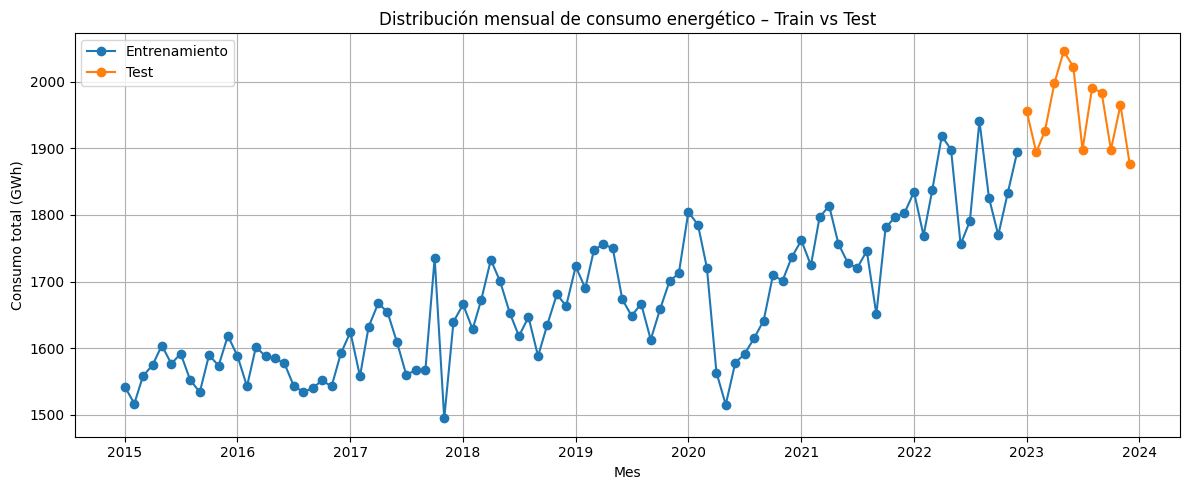

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# === 1. Crear DataFrame para entrenamiento
df_train_plot = pd.DataFrame({
    "Fecha": fechas_train,
    "Energia_GWh": y_train,
    "Tipo": "Entrenamiento"
})

# === 2. Crear DataFrame para test
df_test_plot = pd.DataFrame({
    "Fecha": fechas_test,
    "Energia_GWh": y_test,
    "Tipo": "Test"
})

# === 3. Unir ambos DataFrames
df_plot = pd.concat([df_train_plot, df_test_plot])
df_plot["Mes"] = pd.to_datetime(df_plot["Fecha"]).dt.to_period("M").dt.to_timestamp()

# === 4. Agrupar por mes y tipo
df_mes = df_plot.groupby(["Mes", "Tipo"])["Energia_GWh"].sum().reset_index()

# === 5. Graficar
plt.figure(figsize=(12, 5))
for tipo in df_mes["Tipo"].unique():
    datos = df_mes[df_mes["Tipo"] == tipo]
    plt.plot(datos["Mes"], datos["Energia_GWh"], label=f"{tipo}", marker="o")

plt.title("Distribución mensual de consumo energético – Train vs Test")
plt.xlabel("Mes")
plt.ylabel("Consumo total (GWh)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, Embedding, Concatenate, RepeatVector, Flatten
from tensorflow.keras.callbacks import EarlyStopping

# === 1. Definir entradas ===
input_seq_shape = (X_train.shape[1], X_train.shape[2])  # (12, 5)
num_grupos = len(np.unique(grupo_input_total))          # códigos únicos
embedding_dim = 4

# === 2. Capas de entrada
seq_input = Input(shape=input_seq_shape, name="seq_input")
grupo_input = Input(shape=(1,), name="grupo_input")

# === 3. Embedding para grupo
grupo_embedding = Embedding(input_dim=num_grupos, output_dim=embedding_dim)(grupo_input)
grupo_embedding_flat = Flatten()(grupo_embedding)
grupo_embedding_repeated = RepeatVector(input_seq_shape[0])(grupo_embedding_flat)

# === 4. Combinar secuencia + embedding
merged = Concatenate()([seq_input, grupo_embedding_repeated])

# === 5. Red LSTM
x = LSTM(128, return_sequences=True)(merged)
x = Dropout(0.2)(x)
x = LSTM(64)(x)
x = Dense(32, activation="relu")(x)
output = Dense(1, activation="linear")(x)

# === 6. Definición y compilación
model = Model(inputs=[seq_input, grupo_input], outputs=output)
model.compile(optimizer="adam", loss="mse", metrics=["mae"])

# === 7. Entrenamiento
early_stop = EarlyStopping(monitor="val_loss", patience=15, restore_best_weights=True)

history = model.fit(
    {"seq_input": X_train, "grupo_input": grupo_train},
    y_train,
    validation_split=0.1,
    epochs=50,
    batch_size=64,
    callbacks=[early_stop],
    verbose=1
)


Epoch 1/50
151/151 ━━━━━━━━━━━━━━━━━━━━ 14s 65ms/step - loss: 1105.7418 - mae: 11.9259 - val_loss: 0.9328 - val_mae: 0.6115
Epoch 2/50
151/151 ━━━━━━━━━━━━━━━━━━━━ 8s 49ms/step - loss: 280.0076 - mae: 4.2261 - val_loss: 1.2570 - val_mae: 0.7002
Epoch 3/50
151/151 ━━━━━━━━━━━━━━━━━━━━ 9s 38ms/step - loss: 66.5840 - mae: 2.3933 - val_loss: 0.9077 - val_mae: 0.5502
Epoch 4/50
151/151 ━━━━━━━━━━━━━━━━━━━━ 10s 39ms/step - loss: 26.6318 - mae: 1.8282 - val_loss: 1.1016 - val_mae: 0.6401
Epoch 5/50
151/151 ━━━━━━━━━━━━━━━━━━━━ 10s 39ms/step - loss: 15.8266 - mae: 1.4209 - val_loss: 2.4248 - val_mae: 1.0997
Epoch 6/50
151/151 ━━━━━━━━━━━━━━━━━━━━ 11s 43ms/step - loss: 16.8364 - mae: 1.5210 - val_loss: 0.9366 - val_mae: 0.6381
Epoch 7/50
151/151 ━━━━━━━━━━━━━━━━━━━━ 6s 42ms/step - loss: 18.6964 - mae: 1.4547 - val_loss: 0.8761 - val_mae: 0.5731
Epoch 8/50
151/151 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - loss: 14.2987 - mae: 1.3780 - val_loss: 0.8621 - val_mae: 0.5557
Epoch 9/50
151/151 ━━━━━━━━━━━━━

42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
📊 MÉTRICAS TEST – SOLO 2023:
✅ MAE  : 51.01 GWh
✅ RMSE : 68.00 GWh
✅ MAPE : 2.65 %
✅ R²   : -0.6221


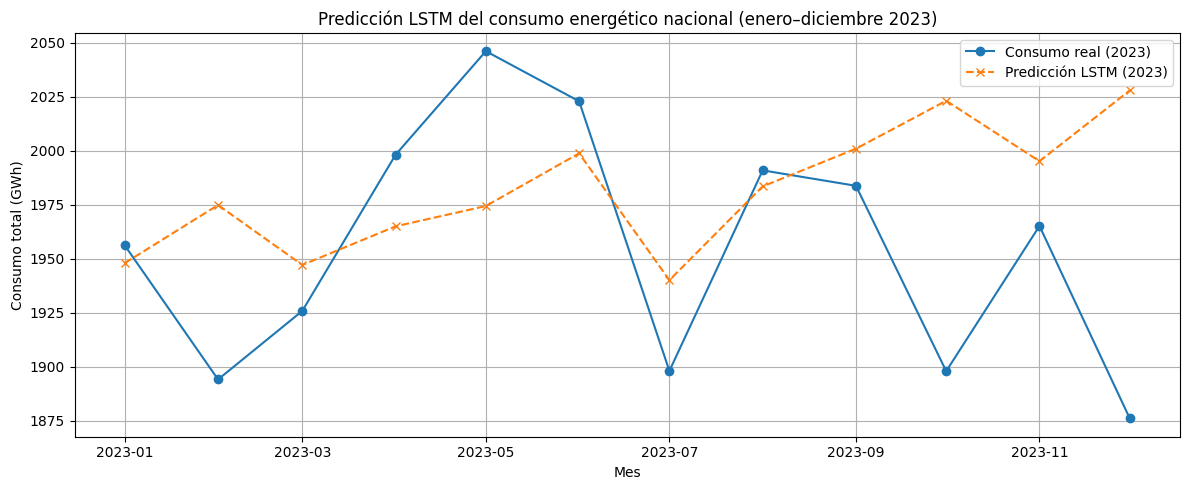

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, r2_score, mean_squared_error
import matplotlib.pyplot as plt
import pandas as pd

# === 1. Predicción sobre test ===
y_pred_test = model.predict({"seq_input": X_test, "grupo_input": grupo_test}).flatten()

# === 2. DataFrame con resultados
df_test_resultados = pd.DataFrame({
    "Fecha": fechas_test,
    "Real": y_test,
    "Pred": y_pred_test
})
df_test_resultados["Mes"] = pd.to_datetime(df_test_resultados["Fecha"]).dt.to_period("M").dt.to_timestamp()

# === 3. Agrupar por mes a nivel nacional
df_test_mensual = df_test_resultados.groupby("Mes")[["Real", "Pred"]].sum()

# === 4. Métricas
mae = mean_absolute_error(df_test_mensual["Real"], df_test_mensual["Pred"])
rmse = np.sqrt(mean_squared_error(df_test_mensual["Real"], df_test_mensual["Pred"]))
mape = mean_absolute_percentage_error(df_test_mensual["Real"], df_test_mensual["Pred"]) * 100
r2 = r2_score(df_test_mensual["Real"], df_test_mensual["Pred"])

print("📊 MÉTRICAS TEST – SOLO 2023:")
print(f"✅ MAE  : {mae:.2f} GWh")
print(f"✅ RMSE : {rmse:.2f} GWh")
print(f"✅ MAPE : {mape:.2f} %")
print(f"✅ R²   : {r2:.4f}")

# === 5. Gráfica
plt.figure(figsize=(12, 5))
plt.plot(df_test_mensual.index, df_test_mensual["Real"], label="Consumo real (2023)", marker="o")
plt.plot(df_test_mensual.index, df_test_mensual["Pred"], label="Predicción LSTM (2023)", marker="x", linestyle="--")
plt.title("Predicción LSTM del consumo energético nacional (enero–diciembre 2023)")
plt.xlabel("Mes")
plt.ylabel("Consumo total (GWh)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


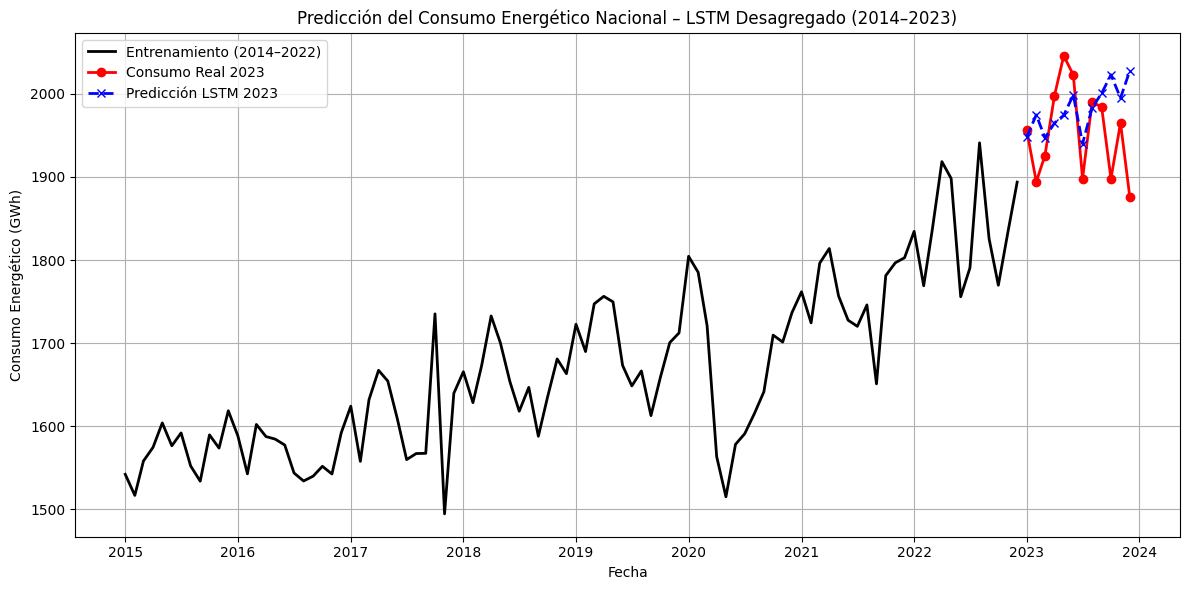

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# === 1. Agrupar entrenamiento por mes (ya que solo tenemos valores reales por muestra)
df_train_plot = pd.DataFrame({
    "Fecha": fechas_train,
    "Energia_GWh": y_train
})
df_train_plot["Mes"] = pd.to_datetime(df_train_plot["Fecha"]).dt.to_period("M").dt.to_timestamp()
df_train_mensual = df_train_plot.groupby("Mes")["Energia_GWh"].sum().reset_index()
df_train_mensual.columns = ["Mes", "Real_GWh"]

# === 2. Preparar test con predicción (ya lo tienes)
df_test_mensual = df_test_resultados.groupby("Mes")[["Real", "Pred"]].sum().reset_index()
df_test_mensual.columns = ["Mes", "Real_GWh", "Prediccion_GWh"]

# === 3. Unir ambas fases
df_entrenamiento = df_train_mensual.copy()
df_test_real = df_test_mensual[["Mes", "Real_GWh"]]
df_test_pred = df_test_mensual[["Mes", "Prediccion_GWh"]]

# === 4. Graficar
plt.figure(figsize=(12, 6))

# Real entrenamiento (2014–2022)
plt.plot(df_entrenamiento["Mes"], df_entrenamiento["Real_GWh"],
         label="Entrenamiento (2014–2022)", color="black", linewidth=2)

# Real test (2023)
plt.plot(df_test_real["Mes"], df_test_real["Real_GWh"],
         label="Consumo Real 2023", color="red", marker="o", linewidth=2)

# Predicción LSTM
plt.plot(df_test_pred["Mes"], df_test_pred["Prediccion_GWh"],
         label="Predicción LSTM 2023", color="blue", linestyle="--", marker="x", linewidth=2)

# Estética
plt.title("Predicción del Consumo Energético Nacional – LSTM Desagregado (2014–2023)")
plt.xlabel("Fecha")
plt.ylabel("Consumo Energético (GWh)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


# 2024


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder

# === 1. Cargar el CSV ===
df = pd.read_csv("df_nn.csv", parse_dates=["Fecha"])

# === 2. Filtrar fechas válidas ===
df2024=df.copy()
df = df[(df["Fecha"] >= "2014-01-01") & (df["Fecha"] <= "2024-12-31")].copy()

# === 3. Eliminar valores negativos
df = df[df["Energia_GWh"] >= 0]

# === 4. Crear columna Mes
df["Mes"] = df["Fecha"].dt.to_period("M").dt.to_timestamp()

# === 5. Identificar series válidas (>=119 meses)
series = df.groupby(["Latitud", "Longitud", "Grupo_Consumo"])["Mes"].nunique().reset_index()
series.columns = ["Lat", "Lon", "Grupo", "Meses_disponibles"]
series_validas = series[series["Meses_disponibles"] >= 119]

# === 6. Filtrar DataFrame a solo series válidas
df = df.merge(series_validas, how="inner", left_on=["Latitud", "Longitud", "Grupo_Consumo"],
              right_on=["Lat", "Lon", "Grupo"])
df = df.drop(columns=["Meses_disponibles", "Lat", "Lon", "Grupo"])

# === 7. Agrupar por provincia + grupo + mes
df_grouped = df.groupby(["Mes", "Grupo_Consumo", "Latitud", "Longitud"], as_index=False)["Energia_GWh"].sum()

# === 8. Agregar estacionalidad
df_grouped["Mes_num"] = df_grouped["Mes"].dt.month
df_grouped["Mes_sin"] = np.sin(2 * np.pi * df_grouped["Mes_num"] / 12)
df_grouped["Mes_cos"] = np.cos(2 * np.pi * df_grouped["Mes_num"] / 12)

# === 9. Codificar grupo de consumo
le_grupo = LabelEncoder()
df_grouped["Grupo_Consumo_Cod"] = le_grupo.fit_transform(df_grouped["Grupo_Consumo"])

# === 10. Verificar
print(df_grouped.head())
print("Series válidas:", df_grouped.groupby(["Latitud", "Longitud", "Grupo_Consumo_Cod"]).ngroups)


         Mes      Grupo_Consumo  Latitud  Longitud  Energia_GWh  Mes_num  \
0 2014-01-01  Alumbrado Público  -3.9931  -79.2042     2.431179        1   
1 2014-01-01  Alumbrado Público  -3.2596  -79.9585     5.421740        1   
2 2014-01-01  Alumbrado Público  -2.9006  -79.0045     6.909779        1   
3 2014-01-01  Alumbrado Público  -2.5489  -78.9382     0.701441        1   
4 2014-01-01  Alumbrado Público  -2.2301  -80.8599     2.157857        1   

   Mes_sin   Mes_cos  Grupo_Consumo_Cod  
0      0.5  0.866025                  0  
1      0.5  0.866025                  0  
2      0.5  0.866025                  0  
3      0.5  0.866025                  0  
4      0.5  0.866025                  0  
Series válidas: 114


In [ ]:
from tqdm import tqdm
import numpy as np

# === 1. Inicialización ===
n_steps = 12
X_total, y_total = [], []
grupo_input_total = []
fechas_total = []
serie_clave_total = []

# === 2. Generar secuencias por serie ===
grupos = df_grouped.groupby(["Latitud", "Longitud", "Grupo_Consumo_Cod"])

for (lat, lon, grupo_cod), group in tqdm(grupos, desc="Procesando series"):
    group = group.sort_values("Mes").reset_index(drop=True)

    if len(group) < n_steps + 1:
        continue

    for i in range(len(group) - n_steps):
        ventana = group.iloc[i:i + n_steps]
        target = group.iloc[i + n_steps]["Energia_GWh"]
        fecha_target = group.iloc[i + n_steps]["Mes"]

        secuencia = ventana[["Energia_GWh", "Mes_sin", "Mes_cos", "Latitud", "Longitud"]].values

        X_total.append(secuencia)
        y_total.append(target)
        grupo_input_total.append(grupo_cod)
        fechas_total.append(fecha_target)
        serie_clave_total.append((lat, lon, grupo_cod))

# === 3. Convertir a arrays ===
X_total = np.array(X_total)
y_total = np.array(y_total)
grupo_input_total = np.array(grupo_input_total)
fechas_total = np.array(fechas_total)
serie_clave_total = np.array(serie_clave_total)

# === 4. Dividir por fecha (test = desde 2024-01-01) ===
fechas_total_ts = pd.to_datetime(fechas_total)
fecha_corte = pd.Timestamp("2024-01-01")

mask_train = fechas_total_ts < fecha_corte
mask_test = fechas_total_ts >= fecha_corte

X_train = X_total[mask_train]
y_train = y_total[mask_train]
grupo_train = grupo_input_total[mask_train]
fechas_train = fechas_total[mask_train]
clave_train = serie_clave_total[mask_train]

X_test = X_total[mask_test]
y_test = y_total[mask_test]
grupo_test = grupo_input_total[mask_test]
fechas_test = fechas_total[mask_test]
clave_test = serie_clave_total[mask_test]

# === 5. Verificar ===
print("✅ División por fecha aplicada correctamente:")
print("Entrenamiento:", fechas_train.min(), "→", fechas_train.max())
print("Test:", fechas_test.min(), "→", fechas_test.max())
print("X_train:", X_train.shape, " | X_test:", X_test.shape)

Procesando series: 100%|██████████| 114/114 [00:10<00:00, 10.49it/s]

✅ División por fecha aplicada correctamente:
Entrenamiento: 2015-01-01 00:00:00 → 2023-12-01 00:00:00
Test: 2024-01-01 00:00:00 → 2024-12-01 00:00:00
X_train: (12283, 12, 5)  | X_test: (1363, 12, 5)


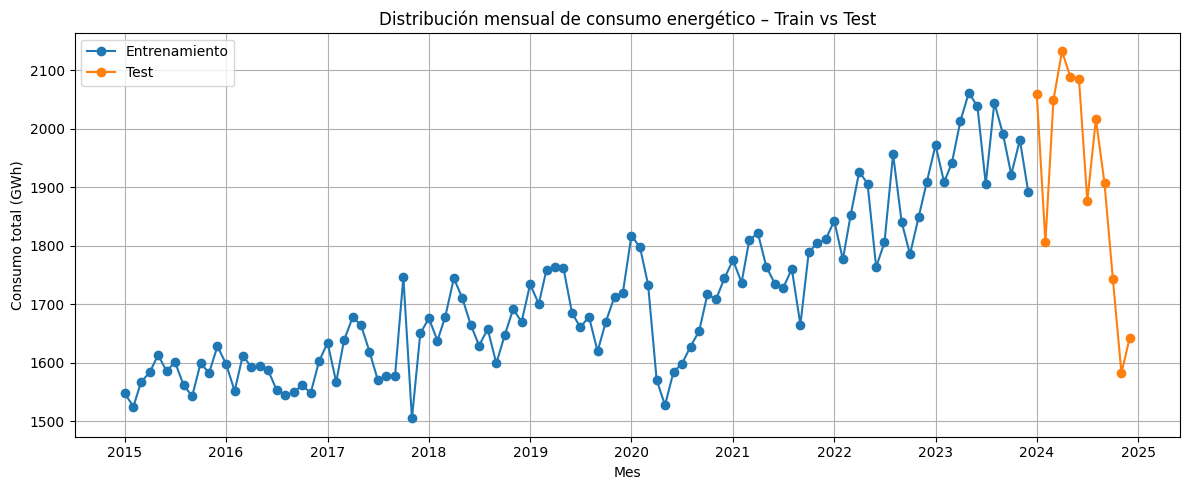

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# === 1. Crear DataFrame para entrenamiento
df_train_plot = pd.DataFrame({
    "Fecha": fechas_train,
    "Energia_GWh": y_train,
    "Tipo": "Entrenamiento"
})

# === 2. Crear DataFrame para test
df_test_plot = pd.DataFrame({
    "Fecha": fechas_test,
    "Energia_GWh": y_test,
    "Tipo": "Test"
})

# === 3. Unir ambos DataFrames
df_plot = pd.concat([df_train_plot, df_test_plot])
df_plot["Mes"] = pd.to_datetime(df_plot["Fecha"]).dt.to_period("M").dt.to_timestamp()

# === 4. Agrupar por mes y tipo
df_mes = df_plot.groupby(["Mes", "Tipo"])["Energia_GWh"].sum().reset_index()

# === 5. Graficar
plt.figure(figsize=(12, 5))
for tipo in df_mes["Tipo"].unique():
    datos = df_mes[df_mes["Tipo"] == tipo]
    plt.plot(datos["Mes"], datos["Energia_GWh"], label=f"{tipo}", marker="o")

plt.title("Distribución mensual de consumo energético – Train vs Test")
plt.xlabel("Mes")
plt.ylabel("Consumo total (GWh)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, Embedding, Concatenate, RepeatVector, Flatten
from tensorflow.keras.callbacks import EarlyStopping

# === 1. Definir entradas ===
input_seq_shape = (X_train.shape[1], X_train.shape[2])  # (12, 5)
num_grupos = len(np.unique(grupo_input_total))          # códigos únicos
embedding_dim = 4

# === 2. Capas de entrada
seq_input = Input(shape=input_seq_shape, name="seq_input")
grupo_input = Input(shape=(1,), name="grupo_input")

# === 3. Embedding para grupo
grupo_embedding = Embedding(input_dim=num_grupos, output_dim=embedding_dim)(grupo_input)
grupo_embedding_flat = Flatten()(grupo_embedding)
grupo_embedding_repeated = RepeatVector(input_seq_shape[0])(grupo_embedding_flat)

# === 4. Combinar secuencia + embedding
merged = Concatenate()([seq_input, grupo_embedding_repeated])

# === 5. Red LSTM
x = LSTM(128, return_sequences=True)(merged)
x = Dropout(0.2)(x)
x = LSTM(64)(x)
x = Dense(32, activation="relu")(x)
output = Dense(1, activation="linear")(x)

# === 6. Definición y compilación
model = Model(inputs=[seq_input, grupo_input], outputs=output)
model.compile(optimizer="adam", loss="mse", metrics=["mae"])

# === 7. Entrenamiento
early_stop = EarlyStopping(monitor="val_loss", patience=15, restore_best_weights=True)

history = model.fit(
    {"seq_input": X_train, "grupo_input": grupo_train},
    y_train,
    validation_split=0.1,
    epochs=50,
    batch_size=64,
    callbacks=[early_stop],
    verbose=1
)


Epoch 1/50
173/173 ━━━━━━━━━━━━━━━━━━━━ 12s 41ms/step - loss: 1037.4697 - mae: 12.2533 - val_loss: 1.4120 - val_mae: 0.7966
Epoch 2/50
173/173 ━━━━━━━━━━━━━━━━━━━━ 8s 48ms/step - loss: 296.3519 - mae: 4.2969 - val_loss: 2.4506 - val_mae: 1.1852
Epoch 3/50
173/173 ━━━━━━━━━━━━━━━━━━━━ 10s 48ms/step - loss: 66.8650 - mae: 2.3799 - val_loss: 0.9400 - val_mae: 0.5571
Epoch 4/50
173/173 ━━━━━━━━━━━━━━━━━━━━ 7s 41ms/step - loss: 23.5494 - mae: 1.6932 - val_loss: 1.4023 - val_mae: 0.9417
Epoch 5/50
173/173 ━━━━━━━━━━━━━━━━━━━━ 10s 56ms/step - loss: 17.5346 - mae: 1.5311 - val_loss: 1.0543 - val_mae: 0.6273
Epoch 6/50
173/173 ━━━━━━━━━━━━━━━━━━━━ 10s 57ms/step - loss: 14.4324 - mae: 1.3551 - val_loss: 1.0943 - val_mae: 0.7335
Epoch 7/50
173/173 ━━━━━━━━━━━━━━━━━━━━ 7s 40ms/step - loss: 13.2312 - mae: 1.3932 - val_loss: 0.8314 - val_mae: 0.5073
Epoch 8/50
173/173 ━━━━━━━━━━━━━━━━━━━━ 8s 48ms/step - loss: 16.5065 - mae: 1.4196 - val_loss: 0.9759 - val_mae: 0.5986
Epoch 9/50
173/173 ━━━━━━━━━━━━━

43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
📊 MÉTRICAS TEST – SOLO 2024:
✅ MAE  : 143.16 GWh
✅ RMSE : 158.18 GWh
✅ MAPE : 7.80 %
✅ R²   : 0.2154


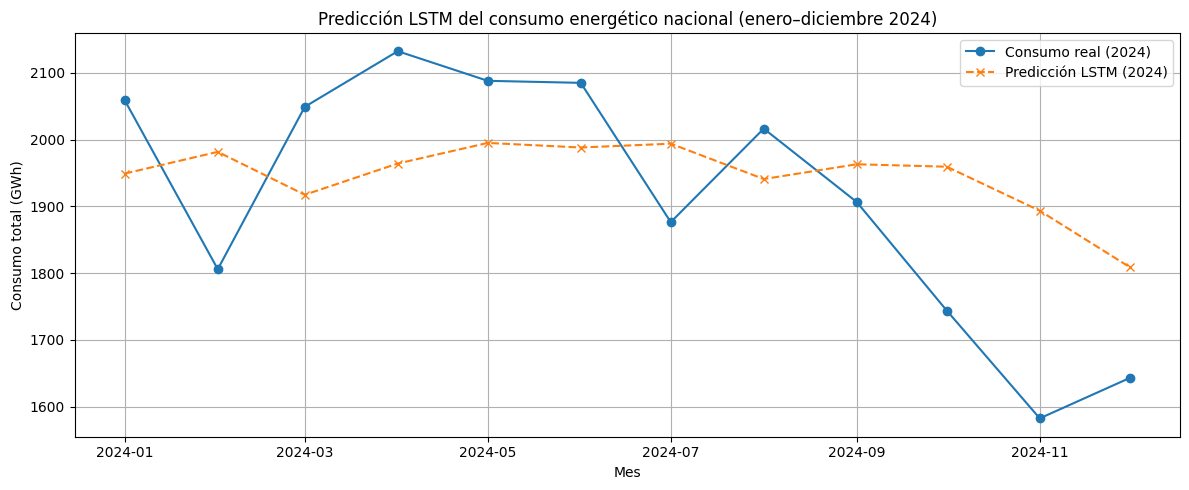

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, r2_score, mean_squared_error
import matplotlib.pyplot as plt
import pandas as pd

# === 1. Predicción sobre test ===
y_pred_test = model.predict({"seq_input": X_test, "grupo_input": grupo_test}).flatten()

# === 2. DataFrame con resultados
df_test_resultados = pd.DataFrame({
    "Fecha": fechas_test,
    "Real": y_test,
    "Pred": y_pred_test
})
df_test_resultados["Mes"] = pd.to_datetime(df_test_resultados["Fecha"]).dt.to_period("M").dt.to_timestamp()

# === 3. Agrupar por mes a nivel nacional
df_test_mensual = df_test_resultados.groupby("Mes")[["Real", "Pred"]].sum()

# === 4. Métricas
mae = mean_absolute_error(df_test_mensual["Real"], df_test_mensual["Pred"])
rmse = np.sqrt(mean_squared_error(df_test_mensual["Real"], df_test_mensual["Pred"]))
mape = mean_absolute_percentage_error(df_test_mensual["Real"], df_test_mensual["Pred"]) * 100
r2 = r2_score(df_test_mensual["Real"], df_test_mensual["Pred"])

print("📊 MÉTRICAS TEST – SOLO 2024:")
print(f"✅ MAE  : {mae:.2f} GWh")
print(f"✅ RMSE : {rmse:.2f} GWh")
print(f"✅ MAPE : {mape:.2f} %")
print(f"✅ R²   : {r2:.4f}")

# === 5. Gráfica
plt.figure(figsize=(12, 5))
plt.plot(df_test_mensual.index, df_test_mensual["Real"], label="Consumo real (2024)", marker="o")
plt.plot(df_test_mensual.index, df_test_mensual["Pred"], label="Predicción LSTM (2024)", marker="x", linestyle="--")
plt.title("Predicción LSTM del consumo energético nacional (enero–diciembre 2024)")
plt.xlabel("Mes")
plt.ylabel("Consumo total (GWh)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


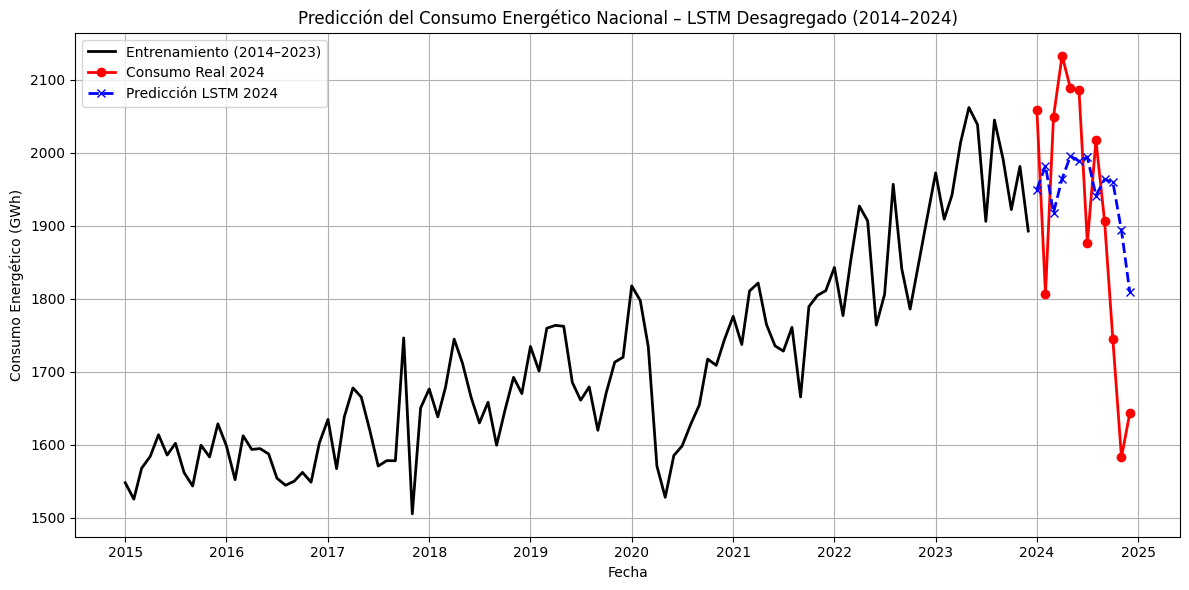

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# === 1. Agrupar entrenamiento por mes (ya que solo tenemos valores reales por muestra)
df_train_plot = pd.DataFrame({
    "Fecha": fechas_train,
    "Energia_GWh": y_train
})
df_train_plot["Mes"] = pd.to_datetime(df_train_plot["Fecha"]).dt.to_period("M").dt.to_timestamp()
df_train_mensual = df_train_plot.groupby("Mes")["Energia_GWh"].sum().reset_index()
df_train_mensual.columns = ["Mes", "Real_GWh"]

# === 2. Preparar test con predicción (ya lo tienes)
df_test_mensual = df_test_resultados.groupby("Mes")[["Real", "Pred"]].sum().reset_index()
df_test_mensual.columns = ["Mes", "Real_GWh", "Prediccion_GWh"]

# === 3. Unir ambas fases
df_entrenamiento = df_train_mensual.copy()
df_test_real = df_test_mensual[["Mes", "Real_GWh"]]
df_test_pred = df_test_mensual[["Mes", "Prediccion_GWh"]]

# === 4. Graficar
plt.figure(figsize=(12, 6))

# Real entrenamiento (2014–2022)
plt.plot(df_entrenamiento["Mes"], df_entrenamiento["Real_GWh"],
         label="Entrenamiento (2014–2023)", color="black", linewidth=2)

# Real test (2023)
plt.plot(df_test_real["Mes"], df_test_real["Real_GWh"],
         label="Consumo Real 2024", color="red", marker="o", linewidth=2)

# Predicción LSTM
plt.plot(df_test_pred["Mes"], df_test_pred["Prediccion_GWh"],
         label="Predicción LSTM 2024", color="blue", linestyle="--", marker="x", linewidth=2)

# Estética
plt.title("Predicción del Consumo Energético Nacional – LSTM Desagregado (2014–2024)")
plt.xlabel("Fecha")
plt.ylabel("Consumo Energético (GWh)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
